In [1]:
import sys
sys.path.append('..')

import os
import numpy as np
import helpers as h
import cv2 as cv
from matplotlib import pyplot as plt
import random as rng
from skimage.morphology import convex_hull_image

In [2]:
patients = h.listdir('../data/input')
print(len(patients))

20


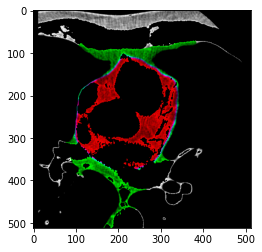

In [3]:
labelled_image = cv.imread('../data/labelled/ACel/009.bmp')
plt.imshow(labelled_image[...,::-1])

In [4]:
def kmeans(img):
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 4
    ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    labels = label.flatten()
    res = center[labels]
    return res, labels

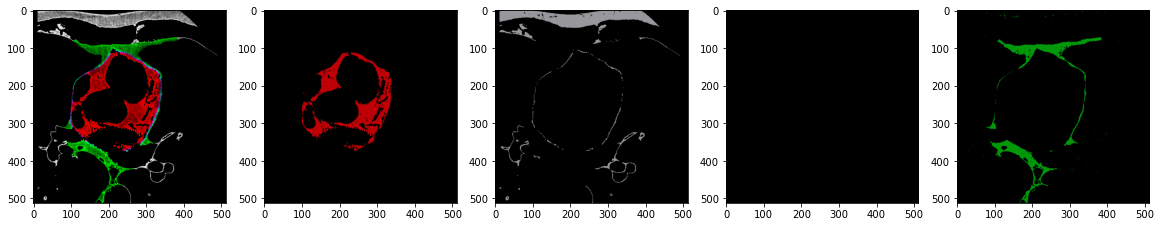

In [5]:
K = 4

def res_to_img(res):
    return res.reshape((labelled_image.shape))[...,::-1]

def show_images(images):
    n = len(images)
    f = plt.figure(figsize=(20,10))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)

meansd, labels = kmeans(labelled_image)
segments = []

for k in range(K):
    curr = meansd.copy()
    curr[labels != k] = [0, 0, 0]
    segments.append(res_to_img(curr))
    
show_images([labelled_image[...,::-1]] + segments)

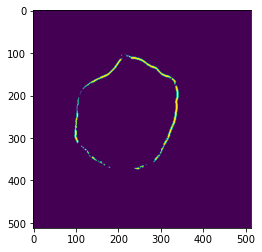

In [6]:
lab_cop = labelled_image.copy()
hsv = cv.cvtColor(lab_cop, cv.COLOR_BGR2HSV)
pericardium = cv.inRange(hsv, (80, 0, 1), (170, 255,255))
plt.imshow(pericardium)

In [7]:
def flatten(lst):
    return [item for sublist in lst for item in sublist]


hull = cv.convexHull(pericardium)
# Draw contours + hull results
drawing = np.zeros((pericardium.shape[0], pericardium.shape[1], 3), dtype=np.uint8)
cv.drawContours(drawing, hull, i, (255, 255, 255))

plt.imshow(drawing)

error: OpenCV(4.5.0) ../modules/imgproc/src/convhull.cpp:143: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'convexHull'


In [ ]:
drawing = np.zeros((pericardium.shape[0], pericardium.shape[1], 3), dtype=np.uint8)
contours, hierarchy = cv.findContours(pericardium, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(drawing, contours, -1, (0, 255, 0), -1)
plt.imshow(drawing)

In [ ]:
points = cv.findNonZero(pericardium)
hull = cv.convexHull(points)
drawing = np.zeros((pericardium.shape[0], pericardium.shape[1], 3), dtype=np.uint8)
cv.drawContours(drawing, hull, -1, (0, 255, 0), -1)

plt.imshow(drawing)

In [ ]:
def to_binary(img):
    return cv.threshold(img, 100, 255, 0)[1]

In [ ]:
binary = to_binary(pericardium)
points = cv.findNonZero(pericardium)
hull = cv.convexHull(points, returnPoints=False)
print(len(hull))
drawing = np.zeros((binary.shape[0], binary.shape[1]), dtype=np.uint8)
cv.drawContours(drawing, hull, -1, (0, 255, 0), -1)
    
plt.imshow(drawing)

In [ ]:
binary = to_binary(pericardium)
chull = convex_hull_image(binary)
binary[chull] += 1
plt.imshow(binary)

In [ ]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour


s = np.linspace(0, 2*np.pi, 200)
r = 250 + 200*np.sin(s)
c = 250 + 200*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(pericardium,
                       init)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(pericardium, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, pericardium.shape[1], pericardium.shape[0], 0])

plt.show()

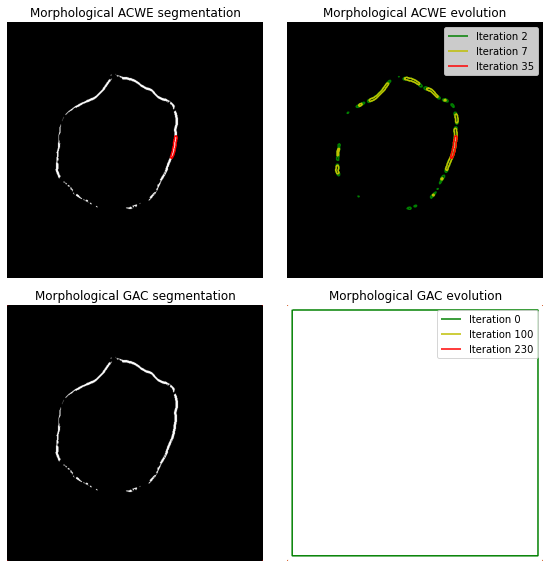

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
image = pericardium.copy()

# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 35, init_level_set=init_ls, smoothing=3,
                             iter_callback=callback)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 35")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)


# Morphological GAC
image = pericardium.copy()
gimage = inverse_gaussian_gradient(image)

# Initial level set
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                           smoothing=1, balloon=1,
                                           threshold=0.69,
                                           iter_callback=callback)

ax[2].imshow(image, cmap="gray")
ax[2].set_axis_off()
ax[2].contour(ls, [0.5], colors='r')
ax[2].set_title("Morphological GAC segmentation", fontsize=12)

ax[3].imshow(ls, cmap="gray")
ax[3].set_axis_off()
contour = ax[3].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[3].contour(evolution[100], [0.5], colors='y')
contour.collections[0].set_label("Iteration 100")
contour = ax[3].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 230")
ax[3].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[3].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()

<ipython-input-49-97804689c4f6>:16: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  snake = active_contour(gaussian(img, 3),


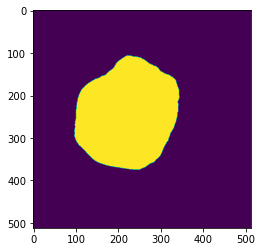

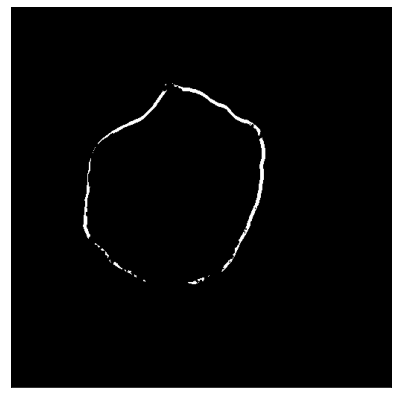

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour


img = pericardium.copy()

s = np.linspace(0, 2*np.pi, 400)
r = pericardium.shape[0] // 2 + pericardium.shape[0] // 2 * np.sin(s)
c = pericardium.shape[0] // 2 + pericardium.shape[0] // 2 * np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.01, beta=1, gamma=0.001, max_iterations=2500)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()


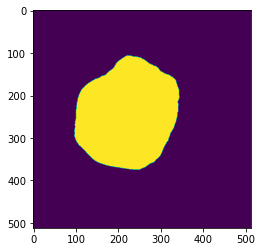

In [50]:
mask = np.zeros(pericardium.shape)
rr, cc = polygon(snake[:, 1], snake[:, 0], mask.shape)
mask[rr, cc] = 1
plt.imshow(mask)

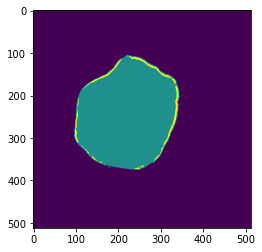

In [53]:
from skimage.util import compare_images

diff = compare_images(pericardium, mask, method='blend')
plt.imshow(diff)

In [20]:
import os
import numpy as np
import helpers as h
import cv2 as cv
from matplotlib import pyplot as plt
import random as rng
from skimage.morphology import convex_hull_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.draw import polygon
from skimage.filters import gaussian
from skimage.segmentation import active_contour

def save_pericardium_mask(file_path):
    image = cv.imread(file_path)
    
    if os.path.exists(file_path.replace('labelled', 'pericardium')):
        return

    # threshold pericardium
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    pericardium = cv.inRange(hsv, (80, 0, 1), (170, 255,255))

    count = cv.countNonZero(pericardium)
    if count == 0:
        mask = np.zeros(pericardium.shape)
        plt.imsave(file_path.replace('labelled', 'pericardium'), mask, cmap="gray")
        return
    
    # active contour around pericardium
    s = np.linspace(0, 2*np.pi, 400)
    r = pericardium.shape[0] // 2 + pericardium.shape[0] // 2 * np.sin(s)
    c = pericardium.shape[0] // 2 + pericardium.shape[0] // 2 * np.cos(s)
    init = np.array([r, c]).T

    snake = active_contour(gaussian(pericardium, 3),
                           init, alpha=0.01, beta=1, gamma=0.001, max_iterations=2500)
    
    # mask from snake
    mask = np.zeros(pericardium.shape)
    rr, cc = polygon(snake[:, 1], snake[:, 0], mask.shape)
    mask[rr, cc] = 1
    
    plt.imsave(file_path.replace('labelled', 'pericardium'), mask, cmap="gray")

In [21]:
patients = h.listdir('../data/labelled/')
patients.sort()
for patient in patients:
    save_folder = '../data/pericardium/' + patient
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    for image_path in h.listdir('../data/labelled/' + patient):
        save_pericardium_mask('../data/labelled/' + patient + '/' + image_path)

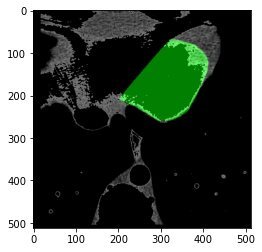

In [99]:
input_img = cv.imread('../data/input/AEdu/IM-0006-0034.BMP')
label = cv.imread('../data/pericardium/AEdu/034.bmp')
label[np.where((label==[255,255,255]).all(axis=2))] = [0,255,0]
overlaid = np.uint8(input_img * 0.5 + label * 0.5)
plt.imshow(overlaid)

In [28]:
# convert dataset to 1-channel PNG and save
import sys
sys.path.append('..')

import os
import numpy as np
import helpers as h
import cv2 as cv
from matplotlib import pyplot as plt
import random as rng
from skimage.morphology import convex_hull_image

DATASET_FOLDER = '../dataset_pericardium/'

h.mkdir(DATASET_FOLDER + 'input')
h.mkdir(DATASET_FOLDER + 'label')

patients = h.listdir('../data/labelled/')

for patient in patients:
    inputs = h.listdir('../data/input/' + patient)
    inputs.sort()
    
    labels = h.listdir('../data/pericardium/' + patient)
    labels.sort()
    
    
    print(patient, len(inputs), len(labels))
    
    h.mkdir(DATASET_FOLDER + 'input/' + patient)
    h.mkdir(DATASET_FOLDER + 'label/' + patient)
    
    for i, label in enumerate(labels):
        file_name = label.replace(".bmp", ".png")
        
        input_img = cv.imread('../data/input/' + patient + '/' + inputs[i])
        label = cv.imread('../data/pericardium/' + patient + '/' + label)
        
        cv.imwrite(DATASET_FOLDER + 'input/' + patient + '/' + file_name, input_img[:, :, 1])
        cv.imwrite(DATASET_FOLDER + 'label/' + patient + '/' + file_name, label[:, :, 1])
#label = cv.imread('../data/pericardium/AEdu/034.bmp')
#cv.imwrite("test.png", label[:, :, 1])

FSiq 43 42
AEdu 41 36
AMar 42 41
VMar 96 44
CFer 43 40
MPai 54 49
MSil 41 41
ISou 42 39
TJes 42 42
JFul 45 44
AFre 43 43
JMir 41 41
DSan 36 36
CLis 36 36
DLag 41 41
DSil 54 50
FGas 48 48
ACel 42 39
AXav 48 43
EGra 48 48
